In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

C:\Python\Anaconda3-52\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [57]:
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(337)

In [58]:
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

In [59]:
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

In [60]:
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [75]:
# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 30            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [76]:
raw_dataframe.head(2)

,Open,High,Low,Close,Adj Close,Volume
0,Open,High,Low,Close,Adj Close,Volume
1,2.437500,2.500000,1.927083,1.958333,1.958333,72156000


In [77]:
# 데이터를 로딩한다.
stock_file_name = 'AMZN.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv('./data/AMZN.csv', names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
 
# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과
 
stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 7 columns):
Date         5179 non-null object
Open         5179 non-null object
High         5179 non-null object
Low          5179 non-null object
Close        5179 non-null object
Adj Close    5179 non-null object
Volume       5179 non-null object
dtypes: object(7)
memory usage: 283.3+ KB
stock_info.shape:  (5178, 6)
stock_info[0]:  [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]


In [78]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다
 
# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용

price.shape:  (5178, 5)
price[0]:  [2.4375   2.5      1.927083 1.958333 1.958333]
norm_price[0]:  [0.00092814 0.00097971 0.00050704 0.00053282 0.00053282]


In [79]:
# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

volume.shape:  (5178, 1)
volume[0]:  [72156000.]
norm_volume[0]:  [0.69017161]


In [87]:
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [-3]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

x.shape:  (5178, 6)
x[0]:  [9.28143131e-04 9.79706638e-04 5.07040880e-04 5.32822633e-04
 5.32822633e-04 6.90171607e-01]
x[-1]:  [0.96451605 0.96645482 0.95354329 0.95758589 0.95758589 0.02142033]
y[0]:  [0.00053282]
y[-1]:  [0.95758589]


In [83]:
# dataX = [] # 입력으로 사용될 Sequence Data
# dataY = [] # 출력(타켓)으로 사용
 
# for i in range(0, len(y) - seq_length):
#     _x = x[i : i+seq_length] # x[0:30] => 0~29개 총 30개
#     _y = y[i + seq_length] # 다음 나타날 주가(정답) y[30] => 31번째 값임!!!
#     if i is 0:
#         print(_x, "->", _y) # 첫번째 행만 출력해 봄
#     dataX.append(_x) # dataX 리스트에 추가
#     dataY.append(_y) # dataY 리스트에 추가

# 출력값을 다시 입력값으로 받는 모델

In [90]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length] # x[0:30] => 0~29개 총 30개
    _y = y[i + seq_length] # 다음 나타날 주가(정답) y[30] => 31번째 값임!!!
    x[30+i][3] = _y
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
        
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[9.28143131e-04 9.79706638e-04 5.07040880e-04 5.32822633e-04
  5.32822633e-04 6.90171607e-01]
 [5.41416826e-04 5.50011019e-04 3.26568604e-04 3.43756990e-04
  3.43756990e-04 1.36869475e-01]
 [3.69538744e-04 3.78132112e-04 2.57817536e-04 3.26568604e-04
  3.26568604e-04 5.41168313e-02]
 [3.43756990e-04 3.60944551e-04 2.66411729e-04 2.66411729e-04
  2.66411729e-04 4.79574739e-02]
 [2.66411729e-04 2.75005097e-04 5.15635073e-05 9.45328216e-05
  9.45328216e-05 1.76864852e-01]
 [1.03127015e-04 1.11721207e-04 0.00000000e+00 6.87510680e-05
  6.87510680e-05 1.08719015e-01]
 [7.73452609e-05 1.71878083e-04 1.71875607e-05 1.54690522e-04
  1.54690522e-04 1.48783729e-01]
 [1.63284715e-04 2.75005097e-04 1.20314575e-04 2.23441590e-04
  2.23441590e-04 7.90662738e-02]
 [2.57817536e-04 2.66411729e-04 1.80472275e-04 1.80472275e-04
  1.80472275e-04 3.93597966e-02]
 [1.89066468e-04 1.89066468e-04 1.37502961e-04 1.58987206e-04
  1.58987206e-04 2.87513723e-02]
 [1.54690522e-04 1.63284715e-04 1.37502961e-04 1.5

In [91]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [92]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

X:  Tensor("Placeholder:0", shape=(?, 30, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [93]:
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [94]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

In [95]:
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

In [96]:
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis:  Tensor("rnn/transpose:0", shape=(?, 30, 20), dtype=float32)


In [97]:
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

학습을 시작합니다...
epoch: 100, train_error(A): 0.0030546742491424084, test_error(B): 0.10442794859409332, B-A: 0.10137327760457993
epoch: 200, train_error(A): 0.0027807129081338644, test_error(B): 0.07886586338281631, B-A: 0.0760851502418518
epoch: 300, train_error(A): 0.002683245809748769, test_error(B): 0.0637020617723465, B-A: 0.061018817126750946
epoch: 400, train_error(A): 0.0026069411542266607, test_error(B): 0.05039776489138603, B-A: 0.04779082536697388
epoch: 500, train_error(A): 0.0025437921285629272, test_error(B): 0.038603223860263824, B-A: 0.0360594317317009
epoch: 600, train_error(A): 0.002488151891157031, test_error(B): 0.028887400403618813, B-A: 0.026399249210953712
epoch: 700, train_error(A): 0.0024370732717216015, test_error(B): 0.021430041640996933, B-A: 0.018992967903614044
epoch: 800, train_error(A): 0.002389605389907956, test_error(B): 0.01616385020315647, B-A: 0.013774245046079159
epoch: 900, train_error(A): 0.0023459417279809713, test_error(B): 0.012784157879650593, B-

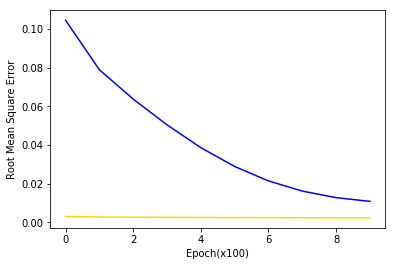

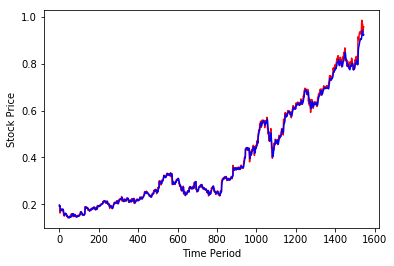

recent_data.shape: (1, 30, 6)
recent_data: [[[0.87189973 0.91103845 0.86563789 0.90721862 0.90721862 0.15482945]
  [0.90231807 0.92523704 0.90112184 0.9153863  0.9153863  0.05899251]
  [0.91386004 0.9151306  0.90735891 0.910791   0.910791   0.02879182]
  [0.91089    0.91383526 0.90374533 0.909471   0.909471   0.03147378]
  [0.90462816 0.90803538 0.89560243 0.90166628 0.90166628 0.0307939 ]
  [0.89913352 0.91689614 0.89696373 0.91600506 0.91600506 0.03143526]
  [0.91398381 0.92739858 0.9136703  0.92347976 0.92347976 0.0278683 ]
  [0.92684578 0.93168037 0.92087268 0.92555055 0.92555055 0.02120337]
  [0.92526172 0.935756   0.92220094 0.93356143 0.93356143 0.02016814]
  [0.92785228 0.93087187 0.91944541 0.93046762 0.93046762 0.03125421]
  [0.92796779 0.93262916 0.92628483 0.92734903 0.92734903 0.01630073]
  [0.92541026 0.93935306 0.92486573 0.93050065 0.93050065 0.02341249]
  [0.93127612 0.93778551 0.92614454 0.93682846 0.93682846 0.0255311 ]
  [0.92871859 0.93262916 0.92428    0.92845453 

In [98]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))
 
 
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
 
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)
 
 
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))
 
# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()
 
 
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

# --------------------------------------------------------------

# LSTM 모델

In [99]:
## import pandas as pd
import pandas_datareader.data as web
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.utils import np_utils

Using TensorFlow backend.


In [100]:
### 데이터 전처리 / Data Preprocessing

np.random.seed(123)
# finance_indicator = test.loc[:,"자산(백만원)":].astype(np.float) # 재부 관련 지표
# month_indicator = test.loc[:,"month"].astype(np.float) # 월 관련 지표

encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
test = pd.read_csv('./data/AMZN.csv', names=names, encoding=encoding, header=0) #판다스이용 csv파일 로딩
test = test.loc[:,'Open':'Volume']
test = test[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']]

indicator = test.values.astype(np.float)
scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링
scaled_test = scaler.fit_transform(indicator) # 가격 관련 지표에 스케일링
#month_indicator = np_utils.to_categorical(month_indicator)

#scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # 0~1 값으로 스케일링
#scaled_etc_indicator = scaler_etc.fit_transform(etc_indicator) # 추세 또는 거래량 활용 지표에 스케일링

In [101]:
x = scaled_test
y = x[:, [5]] # 타켓은 1년뒤 종가이다 / target is 'Close' price


# dataX와 dataY 생성 / Creating dataset 'dataX' and 'dataY'
seq_length = 30 # 4분기 데이터를 이용해 1년뒤 예상

dataX = [] # 입력으로 사용될 Sequence Data / Input - Sequence Data
dataY = [] # 출력(타켓)으로 사용 / Output(target)
for i in range(0, int(len(y) - seq_length)):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
#     x[i+seq_length][5] = _y # 예측된 값을 반영하는 코드
    dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
    dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list
#     print(_x[0:4])
#     print('--------------')
#     print(_y[0])
#     print('--------------')

In [102]:
# 학습용/테스트용 데이터 생성
train_data_size = 0.70
train_size = int(len(dataY) * train_data_size)
test_size = len(dataY) - train_size

In [103]:
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

In [104]:
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print("="*50)
print(_x.shape)
print(_y.shape)
print(trainX.shape)
print(trainY.shape)
print("="*50)

(30, 6)
(1,)
(3603, 30, 6)
(3603, 1)


C:\Python\Anaconda3-52\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Python\Anaconda3-52\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=False, input_shape=(30, 6))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            18176     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________
Train on 3603 samples, validate on 1545 samples
Epoch 1/30
3603/3603 [==============================] - 19s 5ms/step - loss: 4.6652e-05 - val_loss: 2.8386e-04
Epoch 2/30
3603/3603 [==============================] - 18s 5ms/step - loss: 1.7233e-05 - val_loss: 3.7004e-04


No handles with labels found to put in legend.


[4.66519481459791e-05, 1.723305669583382e-05, 1.488050737416029e-05, 1.1396814535896618e-05, 1.3272662262385815e-05, 9.652916021998055e-06, 9.764423747252797e-06, 9.271349367896207e-06, 8.144767523348046e-06, 8.90710079764849e-06, 7.386445307368011e-06, 6.8894312759741265e-06, 6.849572683432271e-06, 7.015575162316607e-06, 5.796483421387878e-06, 7.760035520525654e-06, 5.5943358073314575e-06, 5.474412743505231e-06, 6.255107927078787e-06, 5.6977292017525244e-06, 5.248360593460748e-06, 6.089624092935877e-06, 5.0904660266001135e-06, 5.66605783402212e-06, 5.252191050852303e-06, 5.6934993000559095e-06, 5.745381241717301e-06, 5.342201422660231e-06, 5.813386414718855e-06, 5.399519193051679e-06]
[0.0002838619589953901, 0.00037004085467675003, 0.00034133075161992075, 0.0011628924878042879, 0.0008178577724181894, 0.00014236843949558687, 0.00020456241638744198, 0.00014204963721991607, 0.0003545927140241245, 9.672136660616532e-05, 0.00011477193212249698, 0.00012270960745026203, 0.0003441156311929412

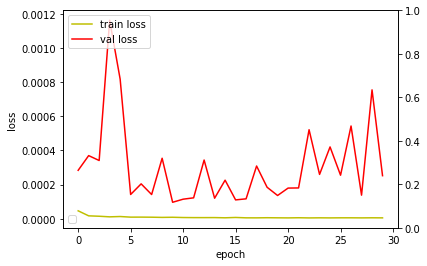

1545/1545 [==============================] - 3s 2ms/step


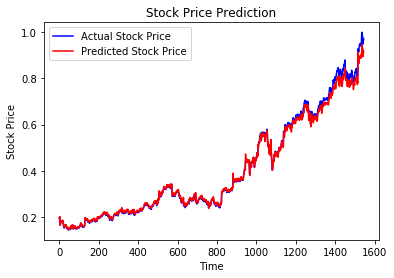

In [105]:
## LSTM 모델

input_columns = 6

model = Sequential()
model.add(LSTM(64, input_dim=input_columns, input_length=seq_length, return_sequences=True, stateful=False))
model.add(LSTM(64, return_sequences=False, stateful=False))
model.add(Dense(1))
model.add(Activation('linear'))
# , dropout=0.2


# 모델 학습 설정 및 진행
keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
print("="*50)
hist = model.fit(trainX, trainY, epochs=30, batch_size=10, verbose=1, validation_data=(testX, testY))


# 학습 과정 살펴보기
print(hist.history['loss'])
print(hist.history['val_loss'])
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()



# 예측
y_pred = model.predict(testX, batch_size=5, verbose=1) # , steps=5
plt.plot(testY, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# 모델 저장
model.save('./save/모든변수예측모델_01.h5')

# cf. 모델 로드하는거!
#model = load_model('./save/lstm_stock_prediction_01.h5')

# For 문으로 모든 변수 예측

In [64]:
## import pandas as pd
import pandas_datareader.data as web
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.utils import np_utils

In [65]:
### 데이터 전처리 / Data Preprocessing

np.random.seed(123)
# finance_indicator = test.loc[:,"자산(백만원)":].astype(np.float) # 재부 관련 지표
# month_indicator = test.loc[:,"month"].astype(np.float) # 월 관련 지표

encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
test = pd.read_csv('./data/AMZN.csv', names=names, encoding=encoding, header=0) #판다스이용 csv파일 로딩
test = test.loc[:,'Open':'Volume']
test = test[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']]

indicator = test.values.astype(np.float)
scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1 값으로 스케일링
scaled_test = scaler.fit_transform(indicator) # 가격 관련 지표에 스케일링
#month_indicator = np_utils.to_categorical(month_indicator)

#scaler_etc = MinMaxScaler(feature_range=(-1, 1)) # 0~1 값으로 스케일링
#scaled_etc_indicator = scaler_etc.fit_transform(etc_indicator) # 추세 또는 거래량 활용 지표에 스케일링

In [66]:
x = scaled_test
y = x[:, [5]] # 타켓은 1년뒤 종가이다 / target is 'Close' price


# dataX와 dataY 생성 / Creating dataset 'dataX' and 'dataY'
seq_length = 30 # 4분기 데이터를 이용해 1년뒤 예상

dataX = [] # 입력으로 사용될 Sequence Data / Input - Sequence Data
dataY = [] # 출력(타켓)으로 사용 / Output(target)
for i in range(0, int(len(y) - seq_length)):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
    dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
    dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list
#     print(_x[0:4])
#     print('--------------')
#     print(_y[0])
#     print('--------------')

In [68]:
# 학습용/테스트용 데이터 생성
train_data_size = 0.70
train_size = int(len(dataY) * train_data_size)
test_size = len(dataY) - train_size

In [69]:
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

In [70]:
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print("="*50)
print(_x.shape)
print(_y.shape)
print(trainX.shape)
print(trainY.shape)
print("="*50)

(30, 6)
(1,)
(3603, 30, 6)
(3603, 1)


C:\Python\Anaconda3-52\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Python\Anaconda3-52\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, stateful=False, input_shape=(30, 6))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 64)            18176     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________
Train on 3603 samples, validate on 1545 samples
Epoch 1/30
3603/3603 [==============================] - 11s 3ms/step - loss: 8.9308e-05 - val_loss: 3.4366e-04
Epoch 2/30
3603/3603 [==============================] - 11s 3ms/step - loss: 1.6601e-05 - val_loss: 3.1463e-04


No handles with labels found to put in legend.


[8.930758994746821e-05, 1.6600585131113643e-05, 1.4701014802932303e-05, 1.4610009836034521e-05, 1.356211676258046e-05, 1.1616436573103442e-05, 1.1187421599704995e-05, 1.0584618709991136e-05, 1.1171086687985129e-05, 1.0085100671235536e-05, 9.947927563407897e-06, 9.489174500306427e-06, 8.954425583890087e-06, 9.443201293334836e-06, 7.61969315286075e-06, 7.742628071530216e-06, 7.362516582935442e-06, 6.766085334430615e-06, 6.660037232138249e-06, 7.000514011131664e-06, 6.438749183142541e-06, 6.256452858808346e-06, 5.9325125769776796e-06, 6.48281999300372e-06, 5.774204187045944e-06, 6.057608772280491e-06, 5.539657991333565e-06, 5.757547758315511e-06, 5.582655425235685e-06, 5.28399914087278e-06]
[0.0003436647690709701, 0.00031463295116262964, 0.0007041803339622843, 0.0002928025818778003, 0.00024144985941774625, 0.00019789288115452578, 0.00027939489012501957, 0.0002663513922628353, 0.00014765858513871615, 0.00018510131889354803, 0.0001262167189013598, 0.00020532247275649042, 0.00028748869177098

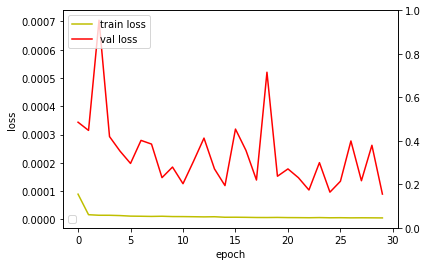

1545/1545 [==============================] - 3s 2ms/step


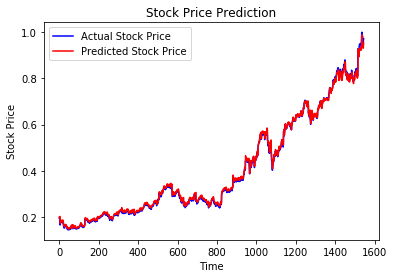

In [71]:
## LSTM 모델

input_columns = 6

model = Sequential()
model.add(LSTM(64, input_dim=input_columns, input_length=seq_length, return_sequences=True, stateful=False))
model.add(LSTM(64, return_sequences=False, stateful=False))
model.add(Dense(1))
model.add(Activation('linear'))
# , dropout=0.2


# 모델 학습 설정 및 진행
keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
print("="*50)
hist = model.fit(trainX, trainY, epochs=30, batch_size=20, verbose=1, validation_data=(testX, testY))


# 학습 과정 살펴보기
print(hist.history['loss'])
print(hist.history['val_loss'])
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()



# 예측
y_pred = model.predict(testX, batch_size=5, verbose=1) # , steps=5
plt.plot(testY, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# 모델 저장
model.save('모든변수예측모델_01.h5')

# cf. 모델 로드하는거!
#model = load_model('lstm_stock_prediction_01.h5')

# 모델 구성
주가, 최고가, 최저가, 수정주가, 거래량 등을 구하고 / 이를 데이터프레임으로 만들고 / 이를 데이터프레임 밑에 붙인다.  

위의 모형은 너무 어렵고 모델을 계속 업데이트 시켜줘야하는 문제가 있다. 따라서 위 방법은 가장 나중에 하자. 가장 완벽한 방법이긴 하다.  
구글 colab 등을 이용해 빨리돌리면 될거같다.  
  
 이번에는 60%를 이용해 30%를 예측하고 예측된 30% 값을 이용해 모델을 만들고 10%값에 대해 다시 맞추는 모델을 만들어 보자!